## 0.0 IMPORTS

In [1]:
# Imports
import pandas as pd # manipulação de dados
import numpy as np

import seaborn as sns # visualizações/gráficos
from matplotlib import pyplot as plt

import pyspark # cluster
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
# https://pypi.org/project/findspark/
!pip install -q findspark

In [3]:
# Importa o findspark e inicializa
import findspark
findspark.init()

### 0.1 Helper Functions

In [4]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.7


In [5]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Camila D'Angelo" --iversions

Author: Camila D'Angelo

seaborn   : 0.11.2
findspark : 2.0.1
pyspark   : 3.3.0
numpy     : 1.20.3
matplotlib: 3.4.3
pandas    : 1.3.4
sys       : 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]



In [6]:
# Formatação das saídas
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

## 1.0 Preparando o Ambiente Spark

In [7]:
# Definindo semente aleatória (seed) para reprodutibilidade do notebook
rnd_seed = 23
np.random.seed = rnd_seed
np.random.set_state = rnd_seed

In [8]:
# Criando o Spark Context
sc = SparkContext(appName = "Mini-Projeto3")

In [9]:
# Criando a sessão Spark
spark_session = SparkSession.Builder().getOrCreate()

In [10]:
# Visualiza o objeto spark_session
spark_session

## LOADING DATA

In [11]:
# Carrega os dados a partir da sessão Spark
df_spark = spark_session.read.csv('dados/dataset.csv', header = 'true', inferSchema = 'true')

In [12]:
# Tipo do objeto
type(df_spark)

pyspark.sql.dataframe.DataFrame

In [13]:
# Visualiza os dados
df_spark.show()

+----------+----+----+----+-----+------------+-----------------+--------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|
+----------+----+----+----+-----+------------+-----------------+--------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|
|1325319300| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319360| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319420| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319480| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319540| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319600| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319660| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325345040| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325345100| NaN| NaN| NaN|  NaN|       

In [14]:
# Visualiza os metadados (schema)
# Nome: tipo
df_spark.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume_(BTC): double (nullable = true)
 |-- Volume_(Currency): double (nullable = true)
 |-- Weighted_Price: double (nullable = true)



In [15]:
# Verifica o número de linhas
df_spark.count()

4856600

## Data Wrangling com SparkSQL

In [16]:
# Cria uma tabela temporária a partir do dataframe
# As tabelas temporárias são úteis quando você deseja que o conjunto de resultados fique visível 
# para todas as outras sessões Spark
df_spark.createOrReplaceTempView('dados_bitcoin') 

In [17]:
# Executa uma consulta SQL
df_bitcoin = spark_session.sql("select *, from_unixtime(Timestamp) as `dateTime` from dados_bitcoin")

In [18]:
type(df_bitcoin)

pyspark.sql.dataframe.DataFrame

In [19]:
# Visualiza os dados
df_bitcoin.show()

+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|           dateTime|
+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|2011-12-31 08:52:00|
|1325319300| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 09:15:00|
|1325319360| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 09:16:00|
|1325319420| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 09:17:00|
|1325319480| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 09:18:00|
|1325319540| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 09:19:00|
|1325319600| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 09:20:00|


> **Remove NA**

In [20]:
# Remove valores NA (não faz sentido qualquer tratamento aqui, pois todas as colunas de cotações estão como NA)
df_bitcoin = df_bitcoin.dropna('any')

In [21]:
# Visualiza os dados
df_bitcoin.show()

+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|           dateTime|
+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|2011-12-31 08:52:00|
|1325346600|4.39|4.39|4.39| 4.39|        48.0|           210.72|          4.39|2011-12-31 16:50:00|
|1325350740| 4.5|4.57| 4.5| 4.57| 37.86229723|     171.38033753|  4.5264114983|2011-12-31 17:59:00|
|1325350800|4.58|4.58|4.58| 4.58|         9.0|            41.22|          4.58|2011-12-31 18:00:00|
|1325391360|4.58|4.58|4.58| 4.58|       1.502|          6.87916|          4.58|2012-01-01 05:16:00|
|1325431680|4.84|4.84|4.84| 4.84|        10.0|             48.4|          4.84|2012-01-01 16:28:00|
|1325457900| 5.0| 5.0| 5.0|  5.0|        10.1|             50.5|           5.0|2012-01-01 23:45:00|


In [22]:
# Número de registros
df_bitcoin.count()

3613769

> **Rename Columns**

In [23]:
# Vamos renomear algumas colunas para facilitar a manipulação dos dados
df_bitcoin = df_bitcoin.withColumnRenamed("Volume_(BTC)", "VolBTC").withColumnRenamed("Volume_(Currency)", "VolCurrency")

In [24]:
# Visualiza
df_bitcoin.show()

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|           dateTime|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31 08:52:00|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 16:50:00|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31 17:59:00|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31 18:00:00|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01 05:16:00|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|        48.4|          4.84|2012-01-01 16:28:00|
|1325457900| 5.0| 5.0| 5.0|  5.0|       10.1|        50.5|           5.0|2012-01-01 23:45:00|
|1325534640| 5.0| 5.0| 5.0|  5.0|     19.048|       95.24|  

> **A coluna dateTime fornece os detalhes da data da cotação**

Vamos separar os elementos da data em diferentes colunas:
* date
* time

In [25]:
# Vamos dividir o dataframe extraindo data
# Cria coluna date
# Atribui primeiro elemento de datetime (antes do espaço)
df_data = df_bitcoin.withColumn("date", split(col("dateTime")," ").getItem(0))

In [26]:
type(df_data)

pyspark.sql.dataframe.DataFrame

In [27]:
# Vamos dividir o dataframe extraindo tempo
# Cria coluna time
# Atribui segundo elemento de datetime (depois do espaço)
df_data = df_data.withColumn("time", split(col("dateTime")," ").getItem(1))

In [28]:
# Schema
df_data.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)



In [29]:
# Visualiza os dados
df_data.show()

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|           dateTime|      date|    time|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31 08:52:00|2011-12-31|08:52:00|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 16:50:00|2011-12-31|16:50:00|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31 17:59:00|2011-12-31|17:59:00|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31 18:00:00|2011-12-31|18:00:00|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01 05:16:00|2012-01-01|05:16:00|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|        48.4|          4.84|2012-01-01 16:2

In [30]:
# Vamos dividir o dataframe extraindo a hora
# Cria coluna hora
# Atribui primeiro elemento de time (antes de :)
df_data_hora = df_data.withColumn("hour", split(col("time"),":").getItem(0))

In [31]:
df_data_hora.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)
 |-- hour: string (nullable = true)



In [32]:
df_data_hora.show()

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+----+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|           dateTime|      date|    time|hour|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31 08:52:00|2011-12-31|08:52:00|  08|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 16:50:00|2011-12-31|16:50:00|  16|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31 17:59:00|2011-12-31|17:59:00|  17|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31 18:00:00|2011-12-31|18:00:00|  18|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01 05:16:00|2012-01-01|05:16:00|  05|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|   

In [33]:
# Vamos ajustar o formato da data para extrair o dia da semana
# Ajustano o tipo de data das colunas: date, hour e datetime (cast)
df_data_hora = df_data_hora.withColumn("date", df_data_hora["date"].cast(DateType())).withColumn("hour", df_data_hora["hour"].cast(DoubleType())).withColumn("dateTime", df_data_hora["dateTime"].cast(DateType()))

In [34]:
df_data_hora.show()

+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|  dateTime|      date|    time|hour|
+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31|2011-12-31|08:52:00| 8.0|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31|2011-12-31|16:50:00|16.0|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31|2011-12-31|17:59:00|17.0|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31|2011-12-31|18:00:00|18.0|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01|2012-01-01|05:16:00| 5.0|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|        48.4|          4.84|2012-01-01|2012-01-01|16:28:00|16.0|
|132545790

In [35]:
# Vamos extrair o dia da semana
# Cria coluna day_of_week
df_data_hora = df_data_hora.withColumn('day_of_week', dayofweek(df_data_hora.date))

In [36]:
df_data_hora.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: date (nullable = true)
 |-- date: date (nullable = true)
 |-- time: string (nullable = true)
 |-- hour: double (nullable = true)
 |-- day_of_week: integer (nullable = true)



In [37]:
# Vamos extrair o ano da cotação
# Cria coluna year
# Atribui primeiro elemento da coluna date (antes de -)
df_data_hora_ano = df_data_hora.withColumn("year", split(col("date"),"-").getItem(0))

In [38]:
df_data_hora_ano.show()

+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+-----------+----+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|  dateTime|      date|    time|hour|day_of_week|year|
+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+-----------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31|2011-12-31|08:52:00| 8.0|          7|2011|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31|2011-12-31|16:50:00|16.0|          7|2011|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31|2011-12-31|17:59:00|17.0|          7|2011|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31|2011-12-31|18:00:00|18.0|          7|2011|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01|2012-01-01|05:16:00| 5.0|  

In [39]:
# Converte o dataframe do Spark para o Pandas. 
# Por quê? Porque isso vai facilitar a análise exploratória de dados.
df_pandas = df_data_hora_ano.toPandas()

In [40]:
type(df_pandas)

pandas.core.frame.DataFrame

In [41]:
# Obtendo os valores individuais para usar nos gráficos
hour = df_pandas["hour"].values.tolist()
weighted_price = df_pandas["Weighted_Price"].values.tolist()
volume_BTC = df_pandas["VolBTC"].values.tolist()
date_of_week = df_pandas["day_of_week"].values.tolist()
year = df_pandas["year"].values.tolist()

## Análise Exploratória

### Target vs Preditoras

<AxesSubplot:>

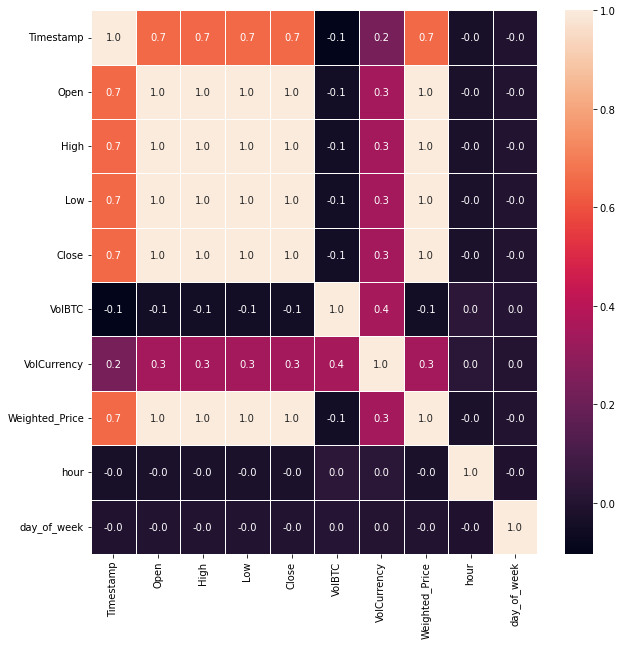

In [42]:
# Heatmap para visualizar a correlação
corr = df_pandas.corr()
f,ax = plt.subplots(figsize = (10, 10))
sns.heatmap(corr, annot = True, linewidths = .5, fmt = '.1f', ax = ax)

> Idealmente queremos:

* **Alta correlação** entre as variáveis preditoras (entrada) e a variável target (saída);
* **Baixa correlação** entre as variáveis preditoras (entrada)

> **Análise**

* **Forte Correlação Positiva** (0.7): Weighted_Price (target) apresenta forte correlação positiva com Timestamp. Entretando o Timestamp é uma coluna de ID, com isso essa correlação não nos indica muita coisa.

* **Fortissíma Correlação possitiva** (1.0): Weighted_Price (target) apresenta uma fortissíma correlação positiva com Open, High, Low e Close.

## Preditoras vs Preditoras

<Figure size 864x360 with 0 Axes>

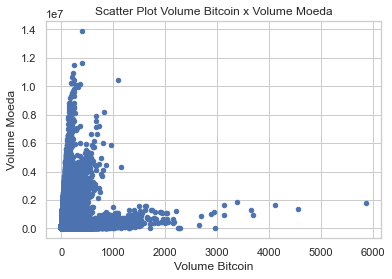

In [43]:
# Scatter Plot Volume Bitcoin x Volume Moeda
plt.figure(figsize = (12,5))
sns.set(style = 'whitegrid')
df_pandas.plot(kind = 'scatter', x = 'VolBTC', y = 'VolCurrency')
plt.xlabel('Volume Bitcoin')            
plt.ylabel('Volume Moeda')
plt.title('Scatter Plot Volume Bitcoin x Volume Moeda') 
plt.show()

# Correlação positiva (0.4)

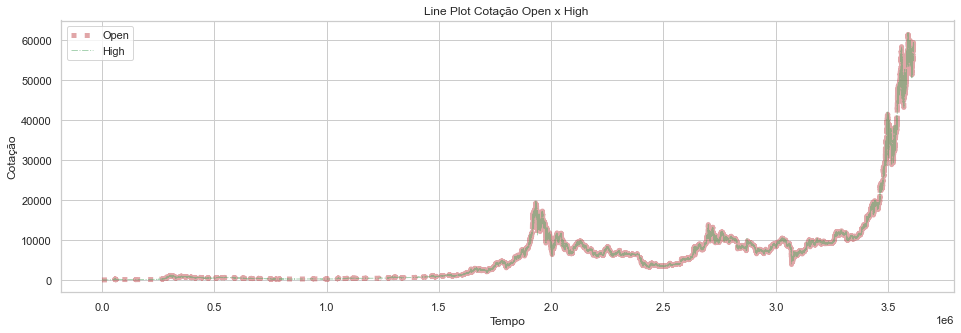

In [44]:
# Line Plot Cotação Open x High 
plt.figure(figsize = (16,5))
df_pandas.Open.plot(kind = 'line', 
                    color = 'r', 
                    label = 'Open', 
                    alpha = 0.5, 
                    linewidth = 5, 
                    grid = True, 
                    linestyle = ':')
df_pandas.High.plot(color = 'g', 
                    label = 'High', 
                    linewidth = 1, 
                    alpha = 0.5, 
                    grid = True, 
                    linestyle = '-.')
plt.legend(loc = 'upper left') 
plt.xlabel('Tempo')
plt.ylabel('Cotação')
plt.title('Line Plot Cotação Open x High ')
plt.show()

# Altíssima correlação positiva (1.0): seguem o mesmo padrão, praticamentes idênticos. Ou seja, devemos escolher umas das 
# duas variavéis. A outra será excluída do algoritmo ML

<AxesSubplot:ylabel='Frequency'>

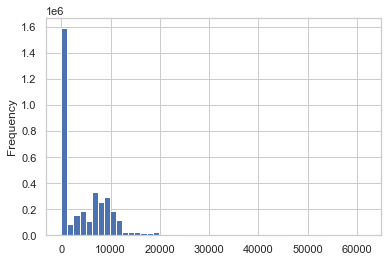

In [45]:
# Histograma da cotação de abertura
df_pandas.Open.plot(kind = 'hist', bins = 50)

# Atenção a valores extremos (outliers)

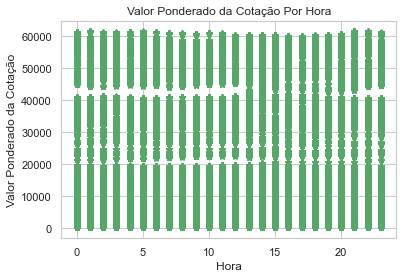

In [46]:
# Plot do valor ponderado da cotação (variável alvo) por hora
plt.plot(hour, weighted_price , 'g*')
plt.xlabel('Hora')            
plt.ylabel('Valor Ponderado da Cotação')
plt.title('Valor Ponderado da Cotação Por Hora') 
plt.show()

# Não há correlação (-0.0) entre as duas variavéis: target e hora

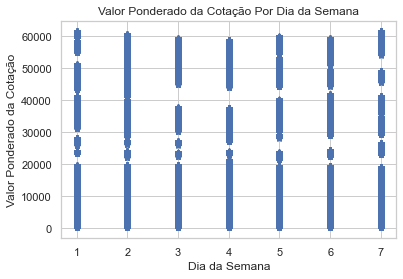

In [47]:
# Plot do valor ponderado da cotação por dia da semana
plt.plot(date_of_week, weighted_price, 'b*')
plt.xlabel('Dia da Semana')            
plt.ylabel('Valor Ponderado da Cotação')
plt.title('Valor Ponderado da Cotação Por Dia da Semana') 
plt.show()

# Não há correlação (-0.0) entre as duas variavéis: target e dia da semana

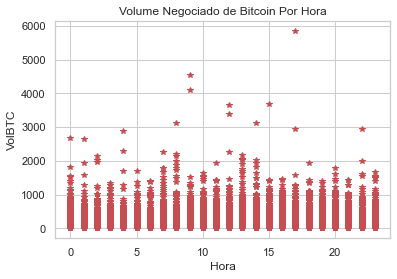

In [48]:
# Plot do VolBTC por hora
plt.plot(hour, volume_BTC, 'r*')
plt.xlabel('Hora')            
plt.ylabel('VolBTC')
plt.title('Volume Negociado de Bitcoin Por Hora') 
plt.show()

# Não há correlação (-0.0) entre as duas variavéis: volBTC e a hora
# Ou seja a hora do dia não parece influenciar a cotação do bitcoin

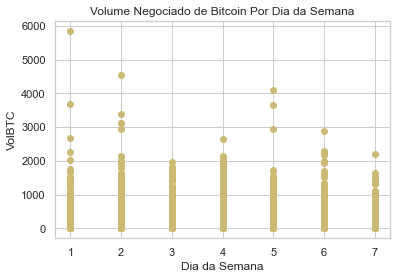

In [49]:
# Plot de VolBTC por dia da semana
plt.plot(date_of_week, volume_BTC, 'yo')
plt.xlabel('Dia da Semana')            
plt.ylabel('VolBTC')
plt.title('Volume Negociado de Bitcoin Por Dia da Semana') 
plt.show()

# Não há correlação (-0.0) entre as duas variavéis: volBTC e dia da semana
# Ou seja, o dia da semana não parece influenciar a cotação do bitcoin

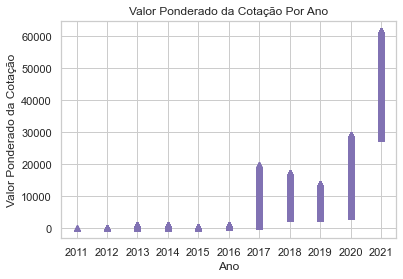

In [50]:
# Plot do valor ponderado da cotação por ano
plt.plot(year, weighted_price , 'm^')
plt.xlabel('Ano')            
plt.ylabel('Valor Ponderado da Cotação')
plt.title('Valor Ponderado da Cotação Por Ano') 
plt.show()

# Podemos observar que ao longo dos anos (a partir de 2017) o volume negociavl aumentou

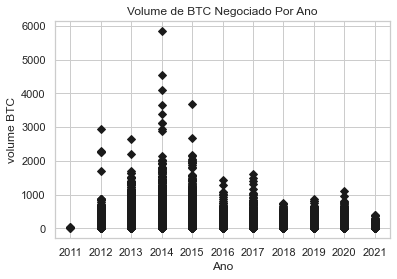

In [51]:
# Plot do Volume por ano
plt.plot(year, volume_BTC , 'kD')
plt.xlabel('Ano')            
plt.ylabel('volume BTC')
plt.title('Volume de BTC Negociado Por Ano') 
plt.show()

# Ano de 2014 (atípico)